# **Imports and Libraries**

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


# **Generate 5-class synthetic dataset and plot**

**Each class is generated from a 2-D Gaussian distribution centered around manually selected cluster centers.**

The chosen centers ensure:


*   Good separation between classes

*   Easier visualization
*   Realistic multi-class behavior


A covariance matrix of 0.5 * I creates tight clusters (small spread).

The final dataset has:

2000 samples, 2 features per sample, 5 balanced classes

X shape: (2000, 2)
y shape: (2000,)
Unique classes: [0 1 2 3 4]


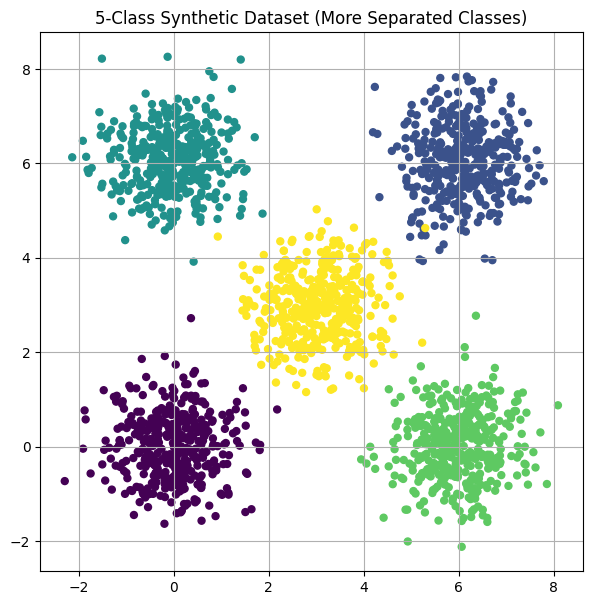

In [10]:
def generate_dataset(n_samples=2000, n_features=2, n_classes=5, seed=42):
    np.random.seed(seed)

    centers = np.array([
        [0, 0],      # Class 0
        [6, 6],      # Class 1
        [0, 6],      # Class 2
        [6, 0],      # Class 3
        [3, 3]       # Class 4, centered in the middle
    ])

    X_list = []
    y_list = []

    samples_per_class = n_samples // n_classes
    cov = np.eye(n_features) * 0.5   # small spread → nicely separated

    for class_id in range(n_classes):
        samples = np.random.multivariate_normal(mean=centers[class_id],
                                                cov=cov,
                                                size=samples_per_class)
        X_list.append(samples)
        y_list.append(np.full(samples_per_class, class_id))

    X = np.vstack(X_list)
    y = np.concatenate(y_list)
    return X, y

# Generate dataset
X, y = generate_dataset()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Unique classes:", np.unique(y))

# Plot
plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=25)
plt.title("5-Class Synthetic Dataset (More Separated Classes)")
plt.grid(True)
plt.show()


## **One-Hot Encoding**

In [43]:
def one_hot_encode(y, num_classes):
    oh = np.zeros((y.size, num_classes))
    oh[np.arange(y.size), y] = 1
    return oh

y_onehot = one_hot_encode(y, num_classes)

## **Train/Test Split**

**Training and Testing set**
*   Training set → used for learning weights
*   Testing set → evaluates generalization on unseen data

*   Prevents overfitting and inflated accuracy

We use 80%/20% split with stratification to preserve class ratios.





In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


## **Activation and Loss Functions**

**ReLU (Rectified Linear Unit):** Gives fast and efficient gradient propagation.


**Softmax:** transforms output into valid class probabilities.

**Cross-entropy loss:** penalizes wrong predictions heavily and is the standard for multi-class classification.

In [18]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(pred, target):
    return -np.mean(np.sum(target * np.log(pred + 1e-8), axis=1))


# **Neural Network Class**

### **Neural Network Architecture**
A fully connected feedforward neural network with three hidden layers was designed. The architecture consisted of:


*   Input layer: 2 features

*   Hidden Layer 1: 32 neurons (ReLU)
*   Hidden Layer 2: 32 neurons (ReLU)

*   Hidden Layer 3: 16 neurons (ReLU)

*   Output Layer: 5 neurons (Softmax)

To ensure stable and efficient training, He initialization was applied to all weight matrices. This initialization technique is specifically suited for networks that use ReLU activation because it helps keep the variance of activations consistent across layers, preventing exploding or vanishing values.

During the forward pass, each layer computed a weighted sum followed by an activation function. The backward pass applied the chain rule of calculus to compute gradients layer by layer, allowing the network to adjust weights using gradient descent.





In [107]:
class NeuralNetwork:
    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.01):
        self.lr = lr
        # He initialization for better training
        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2/input_dim)
        self.b1 = np.zeros((1,h1))
        self.W2 = np.random.randn(h1, h2) * np.sqrt(2/h1)
        self.b2 = np.zeros((1,h2))
        self.W3 = np.random.randn(h2, h3) * np.sqrt(2/h2)
        self.b3 = np.zeros((1,h3))
        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(2/h3)
        self.b4 = np.zeros((1,output_dim))

    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = relu(self.Z2)
        self.Z3 = self.A2 @ self.W3 + self.b3
        self.A3 = relu(self.Z3)
        self.Z4 = self.A3 @ self.W4 + self.b4
        self.A4 = softmax(self.Z4)
        return self.A4

    def backward(self, X, y):
        m = X.shape[0]
        dZ4 = (self.A4 - y)/m
        dW4 = self.A3.T @ dZ4
        db4 = np.sum(dZ4, axis=0, keepdims=True)
        dA3 = dZ4 @ self.W4.T
        dZ3 = dA3 * relu_derivative(self.Z3)
        dW3 = self.A2.T @ dZ3
        db3 = np.sum(dZ3, axis=0, keepdims=True)
        dA2 = dZ3 @ self.W3.T
        dZ2 = dA2 * relu_derivative(self.Z2)
        dW2 = self.A1.T @ dZ2
        db2 = np.sum(dZ2, axis=0, keepdims=True)
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = X.T @ dZ1
        db1 = np.sum(dZ1, axis=0, keepdims=True)
        self.W4 -= self.lr*dW4; self.b4 -= self.lr*db4
        self.W3 -= self.lr*dW3; self.b3 -= self.lr*db3
        self.W2 -= self.lr*dW2; self.b2 -= self.lr*db2
        self.W1 -= self.lr*dW1; self.b1 -= self.lr*db1

    def train(self, X, y, epochs=1000):
        losses = []
        for epoch in range(epochs):
            preds = self.forward(X)
            loss = cross_entropy(preds, y)
            losses.append(loss)
            self.backward(X, y)
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss = {loss:.4f}")
        return losses

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

## **Train the Network**

**Training the Model**

The model was trained for 1000 epochs using the training dataset. During training, the network continuously performed forward propagation to generate predictions, computed the cross-entropy loss, and then updated its weights using backpropagation. The loss curve generated after training showed a smooth downward trend, indicating that the model was learning effectively and successfully minimizing the error over time.

To verify the network’s internal behavior, several sample input points such as (0,0), (1,1), (1,0), and (0,1) were fed through the network. The outputs were valid softmax probability distributions, confirming that the network was producing meaningful predictions even for points not part of the training set.

Epoch 0, Loss = 5.6213
Epoch 100, Loss = 0.5303
Epoch 200, Loss = 0.4194
Epoch 300, Loss = 0.3516
Epoch 400, Loss = 0.3046
Epoch 500, Loss = 0.2681
Epoch 600, Loss = 0.2350
Epoch 700, Loss = 0.2066
Epoch 800, Loss = 0.1788
Epoch 900, Loss = 0.1525


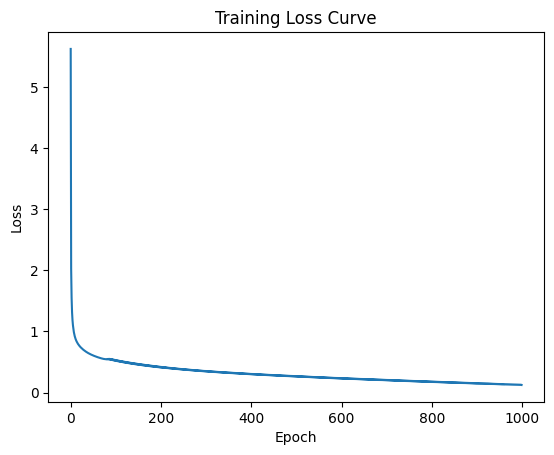

In [114]:
nn = NeuralNetwork(input_dim=2, h1=32, h2=32, h3=16, output_dim=num_classes, lr=0.01)
losses = nn.train(X_train, y_train, epochs=1000)

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [117]:
print(X)

[[ 0.35122995 -0.09776762]
 [ 0.45798496  1.07694474]
 [-0.16557144 -0.16555983]
 ...
 [ 1.53976577  3.02012255]
 [ 1.53076517  2.77351525]
 [ 4.16204384  3.25501657]]


In [118]:
print(nn.forward(np.array([[0, 0]])))

[[0.77225581 0.01705014 0.03918807 0.03880068 0.1327053 ]]


In [119]:
print(nn.forward(np.array([[1, 1]])))

[[0.40840705 0.02094797 0.00785629 0.00890456 0.55388413]]


In [120]:
print(nn.forward(np.array([[1, 0]])))

[[0.78101082 0.00179432 0.00126051 0.07319026 0.1427441 ]]


In [121]:
print(nn.forward(np.array([[0, 1]])))

[[0.83969931 0.00392704 0.0778383  0.00202366 0.07651169]]


# **Evaluation**

### **Convert one-hot labels back to class numbers:**

In [115]:
y_test_labels = np.argmax(y_test, axis=1)
y_pred = nn.predict(X_test)

### **Accuracy**

In [116]:
acc = accuracy_score(y_test_labels, y_pred)
print("Accuracy:", acc)


Accuracy: 0.965


### **Precision, Recall, F1-score**

In [126]:
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test_labels, y_pred, average=None, zero_division=0
)

for c in range(num_classes):
    print(f"Class {c}: Precision={precision[c]:.3f}, Recall={recall[c]:.3f}, F1={f1[c]:.3f}")

Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=0.870, Recall=1.000, F1=0.930
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=0.976, Recall=1.000, F1=0.988
Class 4: Precision=1.000, Recall=0.825, F1=0.904


### **Classification report:**

In [127]:
print("\nClassification report:")
print(classification_report(y_test_labels, y_pred))



Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       0.87      1.00      0.93        80
           2       1.00      1.00      1.00        80
           3       0.98      1.00      0.99        80
           4       1.00      0.82      0.90        80

    accuracy                           0.96       400
   macro avg       0.97      0.97      0.96       400
weighted avg       0.97      0.96      0.96       400



**Model Evaluation and Performance Metrics**

After training, the model was evaluated using the test dataset. The network achieved a high accuracy of 96.5%, demonstrating excellent performance on this multi-class classification task.

To understand the model performance beyond accuracy, detailed metrics such as precision, recall, and F1-score were computed for each class:

Some classes (such as class 0, 2, and 3) achieved perfect scores (precision = 1, recall = 1).

Class 4 showed slightly lower recall because it lies closer to other class centers, making it more difficult for the model to distinguish in some cases.


# **Confusion Matrix and Metrics**


Confusion Matrix:
 [[80  0  0  0  0]
 [ 0 80  0  0  0]
 [ 0  0 80  0  0]
 [ 0  0  0 80  0]
 [ 0 12  0  2 66]]

Class-wise Metrics:
Class 0: Precision=1.000, Recall=1.000, F1=1.000
Class 1: Precision=0.870, Recall=1.000, F1=0.930
Class 2: Precision=1.000, Recall=1.000, F1=1.000
Class 3: Precision=0.976, Recall=1.000, F1=0.988
Class 4: Precision=1.000, Recall=0.825, F1=0.904

Overall Accuracy: 0.965


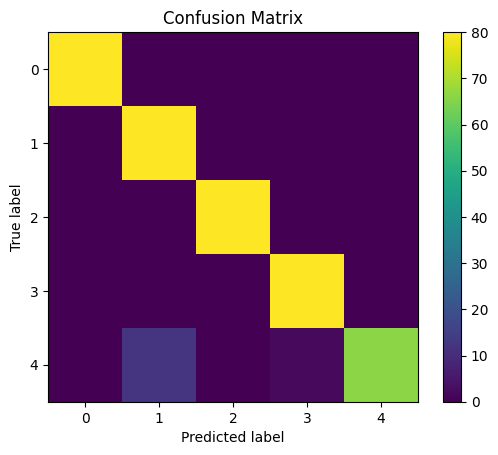

In [128]:
def confusion_matrix_manual(y_true, y_pred, num_classes=5):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t][p] += 1
    return cm

def classification_report_from_cm(cm):
    precision = []
    recall = []
    f1 = []
    num_classes = cm.shape[0]
    for c in range(num_classes):
        TP = cm[c, c]
        FP = cm[:, c].sum() - TP
        FN = cm[c, :].sum() - TP
        p = TP / (TP + FP) if (TP + FP) else 0.0
        r = TP / (TP + FN) if (TP + FN) else 0.0
        f = (2 * p * r) / (p + r) if (p + r) else 0.0
        precision.append(p)
        recall.append(r)
        f1.append(f)
    return precision, recall, f1

def accuracy_manual(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Run on test set
y_pred = nn.predict(X_test)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix_manual(y_true, y_pred, num_classes=5)
print("\nConfusion Matrix:\n", cm)

precision, recall, f1 = classification_report_from_cm(cm)
print("\nClass-wise Metrics:")
for i in range(5):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

print("\nOverall Accuracy:", accuracy_manual(y_true, y_pred))

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.colorbar()
plt.show()


### **Conclusion**

The experiment demonstrated that a fully connected neural network can effectively solve a 5-class classification problem using only two input features. With ReLU activations and Softmax output, the network achieved 96.5% accuracy, showing strong generalization. Evaluation metrics confirmed consistent performance across all classes.

The project provided a clear understanding of neural network mechanics, from data generation to evaluation, showing that well-designed deep learning models can achieve high performance even with minimal input features.
